In [61]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import pandana as pdna
from pandana.loaders import osm
%matplotlib inline
from mpl_toolkits.basemap import Basemap
from pandana.loaders import osm
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
beam_network_nodes = pd.read_csv('beam-network-nodes.csv')
beam_network_nodes.head()

id              x             y         lon        lat
0     0  556999.874645  4.160239e+06 -122.354382  37.587447
1     1  556694.020184  4.160335e+06 -122.357839  37.588328
2    10  524783.388304  4.251499e+06 -122.716128  38.411391
3   100  580390.236693  4.173055e+06 -122.088063  37.701202
4  1000  579889.102807  4.139979e+06 -122.097350  37.403148

In [8]:
access_2010 = pd.read_csv('indicators_output/access_10000_2010_node.csv') #jobs accessibilities by node within 10000m in 2010
access_2010_xy = access_2010.merge(beam_network_nodes, left_index=True, right_index=True)

access_2015 = pd.read_csv('indicators_output/access_10000_2015_node.csv') #jobs accessibilities by node within 10000m in 2010
access_2015_xy = access_2015.merge(beam_network_nodes, left_index=True, right_index=True)

access_2025 = pd.read_csv('indicators_output/access_10000_2025_node.csv') #jobs accessibilities by node within 10000m in 2010
access_2025_xy = access_2025.merge(beam_network_nodes, left_index=True, right_index=True)


In [72]:
access_2025_xy.head()

Unnamed: 0  node_access_nhw  node_access_nhb  node_access_nha  \
0           8         0.000000              0.0    617535.845616   
1          55         0.000000              0.0         0.000000   
2          56    769705.410098              0.0         0.000000   
3          57    764429.397114              0.0         0.000000   
4          58    764947.246263              0.0         0.000000   

   node_access_h    id              x             y         lon        lat  
0            0.0     0  556999.874645  4.160239e+06 -122.354382  37.587447  
1            0.0     1  556694.020184  4.160335e+06 -122.357839  37.588328  
2            0.0    10  524783.388304  4.251499e+06 -122.716128  38.411391  
3            0.0   100  580390.236693  4.173055e+06 -122.088063  37.701202  
4            0.0  1000  579889.102807  4.139979e+06 -122.097350  37.403148

In [37]:
lon_min = min(access_2010_xy['lon'])
lon_max = max(access_2010_xy['lon'])
lat_min = min(access_2010_xy['lat'])
lat_max = max(access_2010_xy['lat'])

output_notebook()
BAY_AREA = x_range, y_range = ((lon_min,lon_max), (lat_min,lat_max)) #((lon_min,lon_max), (lat_min,lat_max))
plot_width  = int(750)
plot_height = int(plot_width//1.2)

def base_plot(tools='pan,wheel_zoom,reset',plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)

    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None

    p.add_tools(BoxZoomTool(match_aspect=True))

    return p

options = dict(line_color=None, fill_color='blue', size=5)

Loading BokehJS ...

In [39]:
import numpy as np

def histogram(x,colors=None):
    hist,edges = np.histogram(x, bins=100)
    p = figure(y_axis_label="Pixels",
               tools='', height=130, outline_line_color=None,
               min_border=0, min_border_left=0, min_border_right=0,
               min_border_top=0, min_border_bottom=0)
    p.quad(top=hist[1:], bottom=0, left=edges[1:-1], right=edges[2:])
    print("min: {}, max: {}".format(np.min(x),np.max(x)))
    show(p)

In [80]:
import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, inferno

lon_min = min(access_2010_xy['lon'])
lon_max = max(access_2010_xy['lon'])
lat_min = min(access_2010_xy['lat'])
lat_max = max(access_2010_xy['lat'])
BAY_AREA = x_range, y_range = ((lon_min,lon_max), (lat_min,lat_max)) #((lon_min,lon_max), (lat_min,lat_max))

background = "black"
export = partial(export_image, export_path="export", background=background)
cm = partial(colormap_select, reverse=(background=="black"))

def create_image(x_range, y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(access_2010_xy, 'lon', 'lat',  ds.sum('node_access_nhb'))
    img = tf.shade(agg, cmap=Hot, how='eq_hist')

    return tf.dynspread(img, threshold=0.5, max_px=4)

p = base_plot(background_fill_color=background)

export(create_image(*BAY_AREA),"datashader_access_nhw")
export(create_image(*BAY_AREA),"datashader_access_nhb")
export(create_image(*BAY_AREA),"datashader_access_nha")
export(create_image(*BAY_AREA),"datashader_access_h")

InteractiveImage(p, create_image)

Text(0.5,0,'Job Accessibility by Race, 2010')

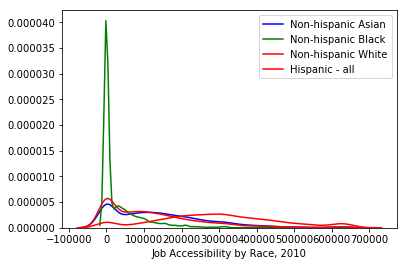

In [69]:
dist_nha_2010 = sns.distplot(access_2010_xy.head(10000)['node_access_nha'], kde=True, hist = False, color= 'b', label = "Non-hispanic Asian")
dist_nhb_2010 = sns.distplot(access_2010_xy.head(10000)['node_access_nhb'], kde=True, hist = False, color= 'g', label = "Non-hispanic Black")
dist_nhw_2010 = sns.distplot(access_2010_xy.head(10000)['node_access_nhw'], kde=True, hist = False, color= 'r', label = "Non-hispanic White")
dist_nhw_2010 = sns.distplot(access_2010_xy.head(10000)['node_access_h'], kde=True, hist = False, color= 'r', label = "Hispanic - all")

plt.xlabel("Node Id")
plt.xlabel("Job Accessibility by Race, 2010")



Text(0.5,0,'Job Accessibility by Race, 2015')

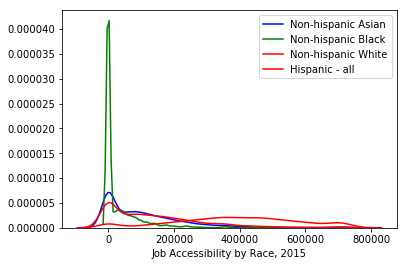

In [70]:
dist_nha_2015 = sns.distplot(access_2015_xy.head(10000)['node_access_nha'], kde=True, hist = False, color= 'b', label = "Non-hispanic Asian")
dist_nhb_2015 = sns.distplot(access_2015_xy.head(10000)['node_access_nhb'], kde=True, hist = False, color= 'g', label = "Non-hispanic Black")
dist_nhw_2015 = sns.distplot(access_2015_xy.head(10000)['node_access_nhw'], kde=True, hist = False, color= 'r', label = "Non-hispanic White")
dist_nhw_2015 = sns.distplot(access_2015_xy.head(10000)['node_access_h'], kde=True, hist = False, color= 'r', label = "Hispanic - all")

plt.xlabel("Node Id")
plt.xlabel("Job Accessibility by Race, 2015")



Text(0.5,0,'Job Accessibility by Race, 2025')

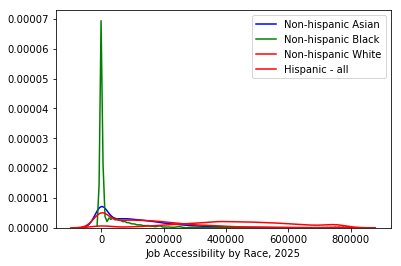

In [71]:
dist_nha_2025 = sns.distplot(access_2025_xy.head(10000)['node_access_nha'], kde=True, hist = False, color= 'b', label = "Non-hispanic Asian")
dist_nhb_2025 = sns.distplot(access_2025_xy.head(10000)['node_access_nhb'], kde=True, hist = False, color= 'g', label = "Non-hispanic Black")
dist_nhw_2025 = sns.distplot(access_2025_xy.head(10000)['node_access_nhw'], kde=True, hist = False, color= 'r', label = "Non-hispanic White")
dist_nhw_2025 = sns.distplot(access_2025_xy.head(10000)['node_access_h'], kde=True, hist = False, color= 'r', label = "Hispanic - all")

plt.xlabel("Node Id")
plt.xlabel("Job Accessibility by Race, 2025")



In [26]:
import numpy as np
from functools import partial

def create_image90(x_range, y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(access_2010_xy, 'lon', 'lat',  ds.count('node_access_nha'))
    img = tf.shade(agg.where(agg>np.percentile(agg,90)), cmap=inferno, how='eq_hist')
    return tf.dynspread(img, threshold=0.3, max_px=4)

p = base_plot()
p.add_tile(CARTODBPOSITRON)
export(create_image(x_range_wm, y_range_wm),"NYCT_90th")
InteractiveImage(p, create_image90)

In [4]:
beam_network_links = pd.read_csv('beam-network-links.csv')
beam_network_nodes = pd.read_csv('beam-network-nodes.csv')

In [5]:
net=pdna.Network(beam_network_nodes.x, beam_network_nodes.y, beam_network_links["from"], beam_network_links["to"],
                 beam_network_links[["travelTime"]])
net.precompute(10000)

